# Libraries

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Loading Data

In [2]:
#load in data
nino = pd.read_csv("Data/nino.csv", keep_default_na=False, na_values=["NaN"])
depress = pd.read_excel('Data/depression.xlsx')
cpi = pd.read_excel('Data/CPI.xlsx')
pop = pd.read_excel('Data/POP.TOTL.xlsx')
gdp = pd.read_excel('Data/GDP.PCA.xlsx')
sunshine = pd.read_excel('Data/cl_Sunshine.xlsx')

#print(sunshine.head())
print(sunshine.head())
print(nino.head())

  Country or Territory  National Annual Avg
0          Afghanistan          2995.630000
1              Albania          2404.683333
2            Argentina          2061.020408
3              Armenia          2457.500000
4            Australia          2746.770000
   Year  nino  nina
0  1970     0     0
1  1971     0     1
2  1972     0     0
3  1973     1     0
4  1974     0     1


# Reformat

In [3]:
# drop columns so that melt will be doable
cpi.drop('Indicator Name', axis=1, inplace=True)
gdp.drop('Indicator Name', axis=1, inplace=True)
gdp.drop('Indicator Code', axis=1, inplace=True)
pop.drop('Indicator Name', axis=1, inplace=True)
pop.drop('Indicator Code', axis=1, inplace=True)

In [4]:
#melt data into usable format
cpi = cpi.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='CPI(% Annual)')
pop = pop.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='Population')
gdp = gdp.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='GDPpc')

# Merge

In [5]:
#change names to make merging easier
depress['Country'] = depress['Entity']
cpi['Country'] = cpi['Country Name']
gdp['Country'] = gdp['Country Name']
pop['Country'] = pop['Country Name']
sunshine['Country'] = sunshine['Country or Territory']
#lag the depression variable
depress['Year'] = depress['Year'] - 2

In [6]:
merger = ['Country', 'Year']
#  We get all the rows from the left dataframe and the matching values from right.
dta = pd.merge(depress, nino, on='Year', how='left')
dta = pd.merge(dta,sunshine, on='Country', how='left')
#merge on list for country-years
econ = pd.merge(pop,cpi, on=merger, how='left')
econ = pd.merge(econ,gdp, on=merger, how='left')
dta = pd.merge(dta, econ, on=merger, how='left')
dta

,Entity,Code,Year,Total Depressive disorders,CPI(% Annual)_x,Country,nino,nina,Country or Territory,National Annual Avg,Country Name_x,Country Code_x,Population,Country Name_y,Country Code_y,CPI(% Annual)_y,Country Name,Country Code,GDPpc
0,Afghanistan,AFG,1988.0,318435.813670,NaN,Afghanistan,1,0,Afghanistan,2995.63,Afghanistan,AFG,11618008.0,Afghanistan,AFG,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1989.0,329044.773956,NaN,Afghanistan,0,1,Afghanistan,2995.63,Afghanistan,AFG,11868873.0,Afghanistan,AFG,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1990.0,382544.572895,NaN,Afghanistan,0,0,Afghanistan,2995.63,Afghanistan,AFG,12412311.0,Afghanistan,AFG,NaN,Afghanistan,AFG,NaN
3,Afghanistan,AFG,1991.0,440381.507393,NaN,Afghanistan,0,0,Afghanistan,2995.63,Afghanistan,AFG,13299016.0,Afghanistan,AFG,NaN,Afghanistan,AFG,NaN
4,Afghanistan,AFG,1992.0,456916.645489,NaN,Afghanistan,1,0,Afghanistan,2995.63,Afghanistan,AFG,14485543.0,Afghanistan,AFG,NaN,Afghanistan,AFG,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Zimbabwe,ZWE,2011.0,303564.603590,3.466130,Zimbabwe,0,1,Zimbabwe,2994.35,Zimbabwe,ZWE,12894323.0,Zimbabwe,ZWE,3.466130,Zimbabwe,ZWE,2101.824051
6464,Zimbabwe,ZWE,2012.0,311665.769283,3.725327,Zimbabwe,0,1,Zimbabwe,2994.35,Zimbabwe,ZWE,13115149.0,Zimbabwe,ZWE,3.725327,Zimbabwe,ZWE,2375.927006
6465,Zimbabwe,ZWE,2013.0,320638.507158,1.634950,Zimbabwe,0,0,Zimbabwe,2994.35,Zimbabwe,ZWE,13350378.0,Zimbabwe,ZWE,1.634950,Zimbabwe,ZWE,2560.773267
6466,Zimbabwe,ZWE,2014.0,330437.353798,-0.197785,Zimbabwe,1,0,Zimbabwe,2994.35,Zimbabwe,ZWE,13586710.0,Zimbabwe,ZWE,-0.197785,Zimbabwe,ZWE,2612.455954


# Preprocess

In [7]:
# clean data
dta['CPI(% Annual)'] = dta['CPI(% Annual)_y']
dta = dta.drop(columns=['Code','Entity','Country or Territory', 'Country Name_x', 'Country Code_x',
'CPI(% Annual)_x','Country Code_y','Country Name_y','CPI(% Annual)_y','Country Code', 'Country Name'])
dta

,Year,Total Depressive disorders,Country,nino,nina,National Annual Avg,Population,GDPpc,CPI(% Annual)
0,1988.0,318435.813670,Afghanistan,1,0,2995.63,11618008.0,NaN,NaN
1,1989.0,329044.773956,Afghanistan,0,1,2995.63,11868873.0,NaN,NaN
2,1990.0,382544.572895,Afghanistan,0,0,2995.63,12412311.0,NaN,NaN
3,1991.0,440381.507393,Afghanistan,0,0,2995.63,13299016.0,NaN,NaN
4,1992.0,456916.645489,Afghanistan,1,0,2995.63,14485543.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6463,2011.0,303564.603590,Zimbabwe,0,1,2994.35,12894323.0,2101.824051,3.466130
6464,2012.0,311665.769283,Zimbabwe,0,1,2994.35,13115149.0,2375.927006,3.725327
6465,2013.0,320638.507158,Zimbabwe,0,0,2994.35,13350378.0,2560.773267,1.634950
6466,2014.0,330437.353798,Zimbabwe,1,0,2994.35,13586710.0,2612.455954,-0.197785


In [8]:
#scale variable for easier use
dta['Depression per 100k'] = dta['Total Depressive disorders']/100000
dta['logDepression100k'] = np.log10(dta['Depression per 100k'])
dta['logGDPpc'] = np.log10(dta['GDPpc'])
dta['logPop'] = np.log10(dta['Population'])
dta['Depressionpc'] = dta['Total Depressive disorders']/dta['Population']
dta['logDepressionpc'] = np.log10(dta['Depressionpc'])
dta['Annual Avg Sunshine Days'] = dta['National Annual Avg']/24
#create polynomial
##depress['sqCPI'] = depress['CPI(% Annual)'] **2
dta['sqSunshine'] = dta['Annual Avg Sunshine Days'] **2
dta['sqlogGDPpc'] = dta['logGDPpc'] **2

# Split

In [9]:
# Set seed
np.random.seed(2)

# break the data up into a training (75%) and test dataset (25%). 

# Train-Test split (using Pandas)
train = dta.sample(frac=.8).reset_index(drop=True)
test = dta.drop(train.index).reset_index(drop=True)
print(test.shape[0],train.shape[0])
dptrain = train.dropna()
dptest = test.dropna()
print(dptest.shape[0],dptrain.shape[0])

1294 5174
419 1890


In [20]:
# generate x values
train_x = dptrain.drop(columns=['Total Depressive disorders','Year','Depression per 100k','Depressionpc',
'Country','National Annual Avg','logDepression100k','logDepressionpc','Population','GDPpc'])
graph_x = train_x.drop(columns=['sqSunshine', 'sqlogGDPpc'])
test_x = dptest.drop(columns=['Total Depressive disorders','Year','Depression per 100k','Depressionpc',
'Country','National Annual Avg','logDepression100k','logDepressionpc','Population','GDPpc'])
# create the y values
train_y1 = dptrain['logDepressionpc']
train_y2 = dptrain['logDepression100k']
test_y1 = dptest['logDepressionpc']
test_y2 = dptest['logDepression100k']

train_x.head()

,nino,nina,CPI(% Annual),logGDPpc,logPop,Annual Avg Sunshine Days,sqSunshine,sqlogGDPpc
2,0,1,1.182956,4.421949,7.770060,59.343958,3521.705391,19.553637
5,0,1,7.850803,4.224846,7.312556,84.759849,7184.231918,17.849326
9,1,0,2.227707,4.273186,5.958425,138.075000,19064.705625,18.260119
15,0,0,2.358604,4.919087,6.732326,84.266667,7100.871111,24.197421
17,0,0,3.631785,4.336048,6.897937,74.119048,5493.633221,18.801315


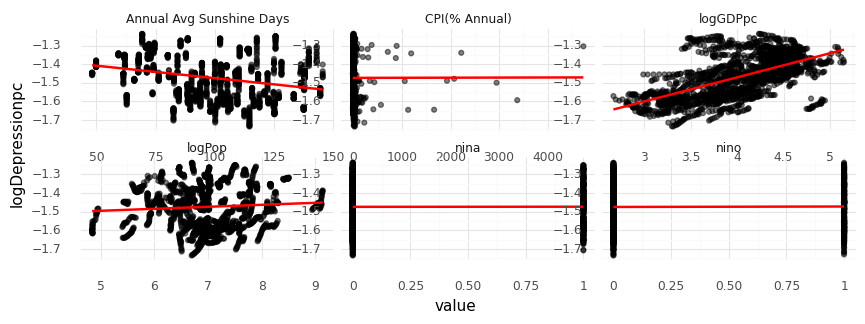

<ggplot: (100278342970)>

In [21]:
D = graph_x.copy()
D['logDepressionpc'] = train_y1

# use visualization to find utility of variables
(
    ggplot(D.melt(id_vars=["logDepressionpc"]),
           aes(x="value",y="logDepressionpc"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

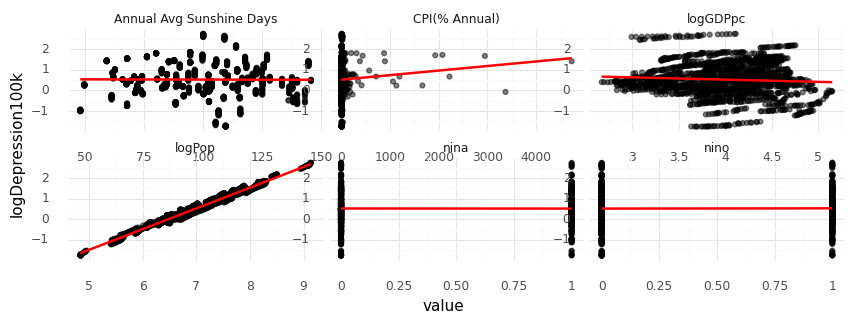

<ggplot: (100278740035)>

In [22]:
D = graph_x.copy()
D['logDepression100k'] = train_y2

# use visualization to find utility of variables
(
    ggplot(D.melt(id_vars=["logDepression100k"]),
           aes(x="value",y="logDepression100k"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)
# this graphing block determined train 2 beats out train 1

# Creating Pipeline

In [25]:
#fold generated with 6 folds
fold_generator = KFold(n_splits=6, shuffle=True,random_state=111)

preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Annual Avg Sunshine Days','nina',
'sqSunshine','CPI(% Annual)','logGDPpc','sqlogGDPpc','nino','logPop'])])

pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])
#pipe = Pipeline(steps=[('model',None)])

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # NaiveBayes
    {'model': [NB()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[35,42,50,75,125,250,380]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[3,4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[200,250,300,500,1000,1250]},
]

In [26]:
#fit model to data, based on different scoring mechanisms 
search1 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring= 'neg_mean_squared_error',
                      n_jobs=5)
search1.fit(train_x,train_y2)
search2 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring= 'roc_auc',
                      n_jobs=5)
search2.fit(train_x,train_y2)

GridSearchCV(cv=KFold(n_splits=6, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Annual '
                                                                          'Avg '
                                                                          'Sunshine '
                                                                          'Days',
                                                                          'nina',
                                                                          'sqSunshine',
                                                                          'CPI(% '
                                                                          'Annual)',
                                      

In [27]:
# collect estimators
rf_mod1 = search1.best_estimator_
rf_mod2 = search2.best_estimator_
print(rf_mod1)
print(rf_mod2)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Annual Avg Sunshine Days',
                                                   'nina', 'sqSunshine',
                                                   'CPI(% Annual)', 'logGDPpc',
                                                   'sqlogGDPpc', 'nino',
                                                   'logPop'])])),
                ('model', BaggingRegressor())])
Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Annual Avg Sunshine Days',
                                                   'nina', 'sqSunshine',
                                                   'CPI(% Annual)', 'logGDPpc',
                                                   'sqlogGDPpc', 'nino',
                                                   'logPop'])])),


# Checking Pipeline

In [29]:
#define estimate values for each variable

vi = permutation_importance(rf_mod1,train_x,train_y2,n_repeats=5)
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But order from most to least important
vi_dat1 = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
print(vi_dat1)

                   variable        vi           std       low      high
0                    logPop  1.945133  2.951520e-02  1.886103  2.004163
1                  logGDPpc  0.004732  1.868014e-04  0.004358  0.005105
2                sqlogGDPpc  0.003999  1.039932e-04  0.003791  0.004207
3  Annual Avg Sunshine Days  0.003539  1.094326e-04  0.003321  0.003758
4                sqSunshine  0.003314  7.852116e-05  0.003157  0.003471
5             CPI(% Annual)  0.000712  2.683052e-05  0.000658  0.000766
6                      nina  0.000009  7.583510e-07  0.000007  0.000010
7                      nino  0.000007  5.382521e-07  0.000006  0.000008


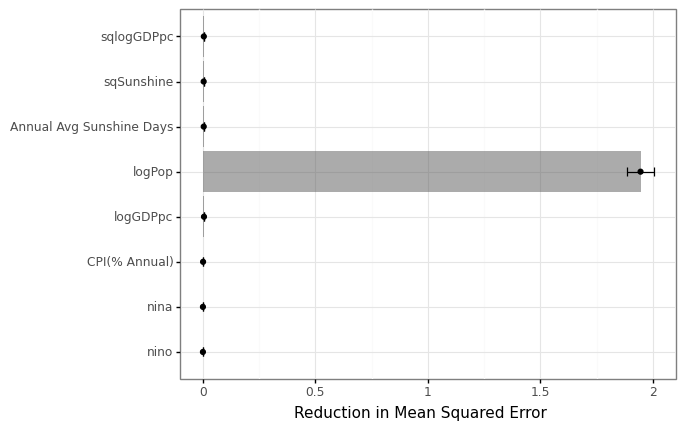

<ggplot: (100280191531)>

In [30]:
# Plot
(
    ggplot(vi_dat1,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in Mean Squared Error",x="")
)

In [31]:
#define estimate values for each variable

vi = permutation_importance(rf_mod2,train_x,train_y2,n_repeats=5)
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat2 = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat2

,variable,vi,std,low,high
0,logPop,1.966070,0.035116,1.895839,2.036302
1,logGDPpc,0.119412,0.002235,0.114943,0.123881
2,sqlogGDPpc,0.052221,0.001391,0.049439,0.055002
3,Annual Avg Sunshine Days,0.019376,0.000334,0.018708,0.020045
4,sqSunshine,0.016056,0.000628,0.014800,0.017312
5,CPI(% Annual),0.000041,0.000025,-0.000009,0.000091
6,nina,0.000021,0.000014,-0.000006,0.000048
7,nino,0.000007,0.000008,-0.000009,0.000023


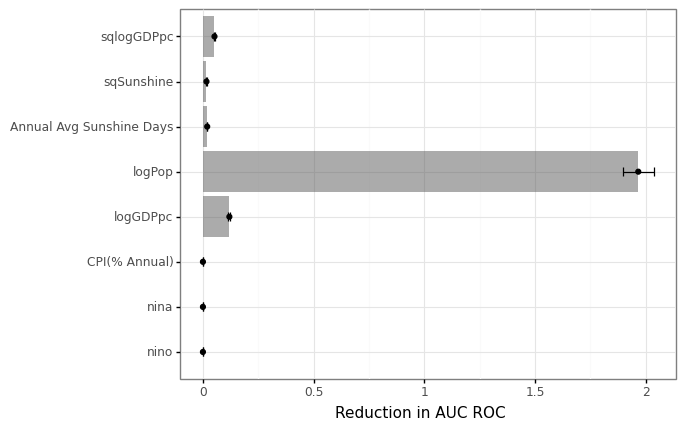

<ggplot: (100279042479)>

In [32]:
# Plot
(
    ggplot(vi_dat2,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

# Prediction

In [33]:
# Predict() method will use the best model out of the scan
pred_y1 = search1.predict(test_x)
pred_y2 = search2.predict(test_x)
print(m.mean_squared_error(test_y2,pred_y1))
print(m.mean_squared_error(test_y2,pred_y2))

0.0003927387621985452
0.004880191690820832


In [34]:
print(m.r2_score(test_y2,pred_y1))
print(m.r2_score(test_y2,pred_y2))

0.9989675418161086
0.9871706224719432


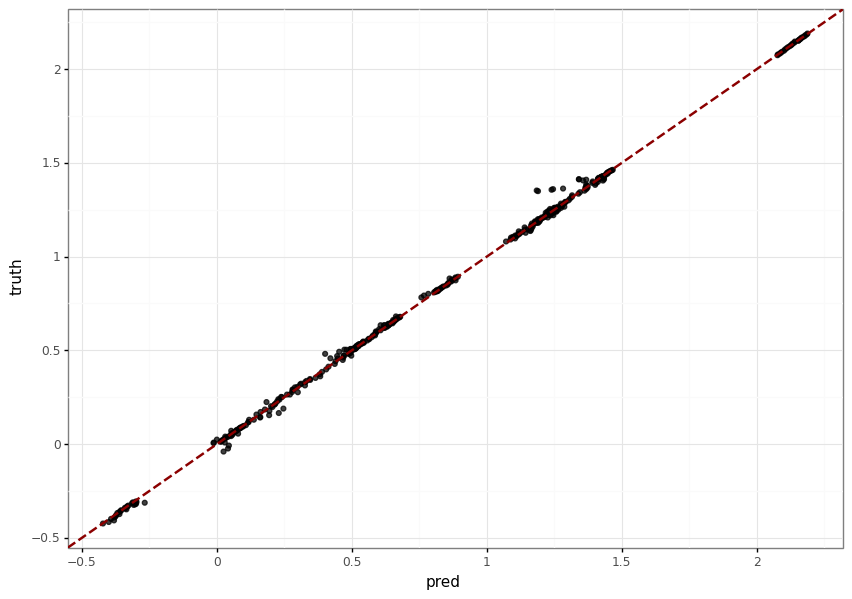

<ggplot: (100280405378)>

In [35]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y1,truth=test_y2)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)
#first methodology outperforms second scoring method

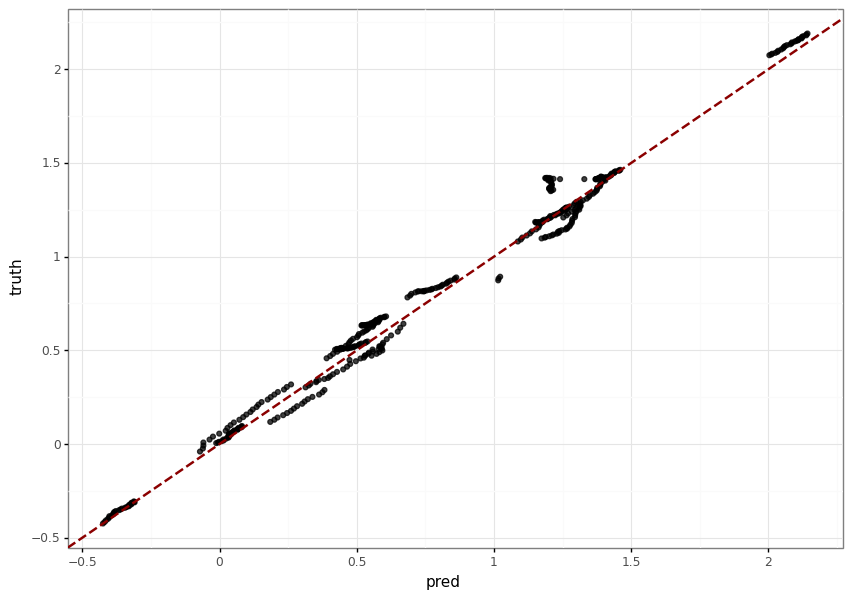

<ggplot: (100280344046)>

In [36]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y2,truth=test_y2)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)